In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from tensorflow import random
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import r2_score

# 固定随机种子
np.random.seed(10086)
random.set_seed(10010)

In [0]:
csv_data = keras.utils.get_file("PRSA_data.csv", "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv")

In [0]:
raw_df = pd.read_csv(csv_data)

In [5]:
raw_df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [0]:
# 删除时间戳
df = raw_df.drop(["No", "year", "month", "day", "hour"], axis=1, inplace=False)

In [7]:
print(df.shape)
df.head()

(43824, 8)


,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [0]:
# 删除 pm2.5 列的 nan 值
df = df[pd.notna(df["pm2.5"])]

In [9]:
print(df.shape)
df.head()

(41757, 8)


,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,159.0,-11,-5.0,1021.0,SE,3.57,0,0
27,181.0,-7,-5.0,1022.0,SE,5.36,1,0
28,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [10]:
# 查看每列的 unique
for i in range(df.shape[1]):
    if df.columns[i] in ["pm2.5", "TEMP", "DEWP", "PRES"]:
        continue
    print("{}: {}".format(df.columns[i], df[df.columns[i]].unique()))

cbwd: ['SE' 'cv' 'NW' 'NE']
Iws: [  1.79   2.68   3.57 ... 242.7  246.72 249.85]
Is: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 19 20 21 22 23 24 25
 26 27 14 18]
Ir: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]


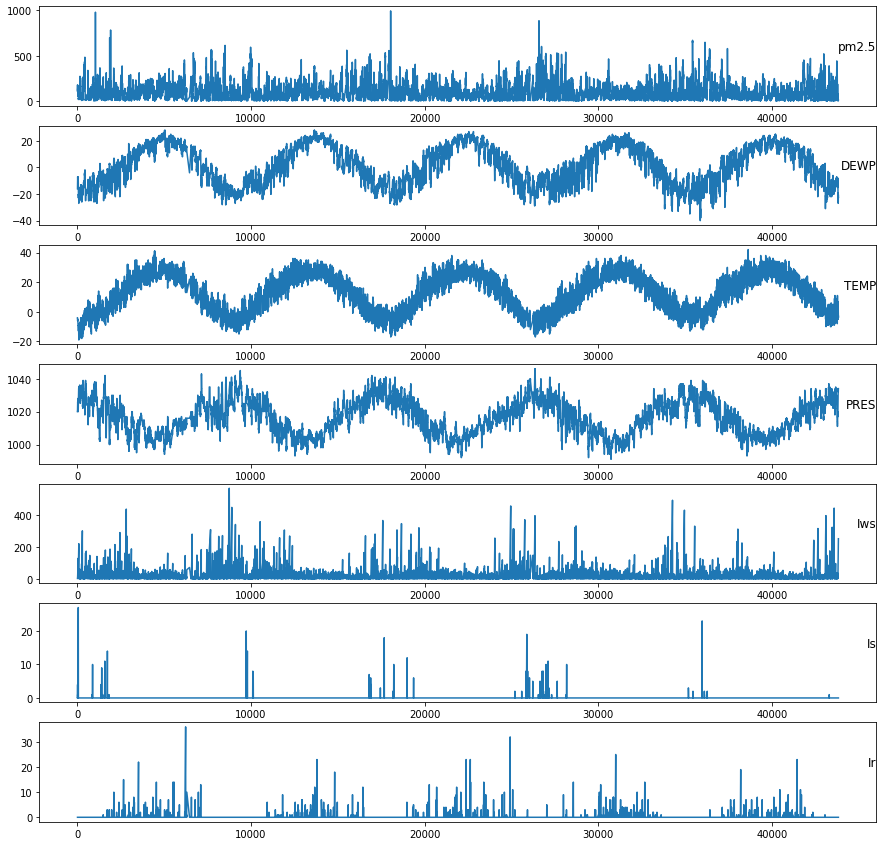

In [11]:
# 画个图
columns = ["pm2.5", "DEWP", "TEMP", "PRES", "Iws", "Is", "Ir"]

plt.figure(figsize=(15, 15))
for i, each in enumerate(columns):
    plt.subplot(len(columns), 1, i + 1)
    plt.plot(df[each])
    plt.title(each, y = 0.5, loc="right") # center, left, right

plt.show()

In [0]:
# 转化为监督序列
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    from pandas import DataFrame, concat

    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (data.columns[j], i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (data.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (data.coumns[j], i)) for j in range(n_vars)]

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [0]:
# 将 label id 化
def label_fit_transform(data_frame, col_name):

    data_frame[col_name] = preprocessing.LabelEncoder().fit_transform(data_frame[col_name])
    return data_frame

In [14]:
label_fit_transform(df, "cbwd").head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,129.0,-16,-4.0,1020.0,2,1.79,0,0
25,148.0,-15,-4.0,1020.0,2,2.68,0,0
26,159.0,-11,-5.0,1021.0,2,3.57,0,0
27,181.0,-7,-5.0,1022.0,2,5.36,1,0
28,138.0,-7,-5.0,1022.0,2,6.25,2,0


In [0]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

def standardization(data_frame):
    buffer = data_frame.copy()
    standard_values = min_max_scaler.fit_transform(buffer)
    for i, col_name in enumerate(buffer.columns):
        buffer[col_name] = standard_values[:, i]

    return buffer

def inverse_standardization(data_frame):
    buffer = data_frame.copy()
    buffer = min_max_scaler.inverse_transform(buffer)
    return buffer

In [16]:
standardization(df).head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,0.129779,0.352941,0.245902,0.527273,0.666667,0.002372,0.000000,0.0
25,0.148893,0.367647,0.245902,0.527273,0.666667,0.003947,0.000000,0.0
26,0.159960,0.426471,0.229508,0.545455,0.666667,0.005522,0.000000,0.0
27,0.182093,0.485294,0.229508,0.563636,0.666667,0.008690,0.037037,0.0
28,0.138833,0.485294,0.229508,0.563636,0.666667,0.010265,0.074074,0.0


In [0]:
# 通过过去 2 天的数据来预测未来 1 天的数据
look_back = 2
predict_forward = 1

In [0]:
# standard (supervised) data frame
sdf = series_to_supervised(
    standardization(
        label_fit_transform(df, "cbwd")), look_back, predict_forward).drop(
        [
         "DEWP(t)", "TEMP(t)", "PRES(t)", "cbwd(t)", "Iws(t)", "Is(t)", "Ir(t)"
         ], axis=1, inplace=False).astype('float32')

In [19]:
sdf.head()

,pm2.5(t-2),DEWP(t-2),TEMP(t-2),PRES(t-2),cbwd(t-2),Iws(t-2),Is(t-2),Ir(t-2),pm2.5(t-1),DEWP(t-1),TEMP(t-1),PRES(t-1),cbwd(t-1),Iws(t-1),Is(t-1),Ir(t-1),pm2.5(t)
26,0.129779,0.352941,0.245902,0.527273,0.666667,0.002372,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003947,0.000000,0.0,0.159960
27,0.148893,0.367647,0.245902,0.527273,0.666667,0.003947,0.000000,0.0,0.159960,0.426471,0.229508,0.545455,0.666667,0.005522,0.000000,0.0,0.182093
28,0.159960,0.426471,0.229508,0.545455,0.666667,0.005522,0.000000,0.0,0.182093,0.485294,0.229508,0.563636,0.666667,0.008690,0.037037,0.0,0.138833
29,0.182093,0.485294,0.229508,0.563636,0.666667,0.008690,0.037037,0.0,0.138833,0.485294,0.229508,0.563636,0.666667,0.010265,0.074074,0.0,0.109658
30,0.138833,0.485294,0.229508,0.563636,0.666667,0.010265,0.074074,0.0,0.109658,0.485294,0.213115,0.563636,0.666667,0.011840,0.111111,0.0,0.105634


In [20]:
sdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41755 entries, 26 to 43823
Data columns (total 17 columns):
pm2.5(t-2)    41755 non-null float32
DEWP(t-2)     41755 non-null float32
TEMP(t-2)     41755 non-null float32
PRES(t-2)     41755 non-null float32
cbwd(t-2)     41755 non-null float32
Iws(t-2)      41755 non-null float32
Is(t-2)       41755 non-null float32
Ir(t-2)       41755 non-null float32
pm2.5(t-1)    41755 non-null float32
DEWP(t-1)     41755 non-null float32
TEMP(t-1)     41755 non-null float32
PRES(t-1)     41755 non-null float32
cbwd(t-1)     41755 non-null float32
Iws(t-1)      41755 non-null float32
Is(t-1)       41755 non-null float32
Ir(t-1)       41755 non-null float32
pm2.5(t)      41755 non-null float32
dtypes: float32(17)
memory usage: 3.0 MB


In [0]:
# train, valid, test 6:2:2 划分
total = sdf.shape[0]
split_point = [total * 60 // 100, total * 80 // 100]

In [22]:
print("total = {}, split_point = {}".format(total, split_point))

total = 41755, split_point = [25053, 33404]


In [0]:
def transform(values):
    return values.reshape(values.shape[0], 1, values.shape[1])

In [0]:
train_data = sdf[:split_point[0]].values

valid_data = sdf[split_point[0]: split_point[1]].values

test_data = sdf[split_point[1]: ].values

In [25]:
print("train_data.shape = {}, valid_data.shape = {}, test_data.shape = {}".format(
    train_data.shape, valid_data.shape, test_data.shape))

train_data.shape = (25053, 17), valid_data.shape = (8351, 17), test_data.shape = (8351, 17)


In [0]:
train_x, train_y = transform(train_data[:, : -1]), train_data[:, -1]

valid_x, valid_y = transform(valid_data[:, : -1]), valid_data[:, -1]

test_x, test_y = transform(test_data[:, : -1]), test_data[:, -1]

In [27]:
print("train_x.shape = {}, train_y = {}".format(train_x.shape, train_y.shape))
print("valid_x.shape = {}, valid_y = {}".format(valid_x.shape, valid_y.shape))
print("test_x.shape = {}, test_y = {}".format(test_x.shape, test_y.shape))

train_x.shape = (25053, 1, 16), train_y = (25053,)
valid_x.shape = (8351, 1, 16), valid_y = (8351,)
test_x.shape = (8351, 1, 16), test_y = (8351,)


In [0]:
model = keras.Sequential()
model.add(keras.layers.LSTM(64, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(keras.layers.Dense(1))

model.compile(loss="mae", optimizer="adam")

In [29]:
history = model.fit(train_x,
                    train_y,
                    validation_data=(valid_x, valid_y),
                    epochs=32,
                    batch_size=32,
                    verbose=1,
                    shuffle=False)

Train on 25053 samples, validate on 8351 samples
Epoch 1/32
25053/25053 [==============================] - 6s 224us/sample - loss: 0.0263 - val_loss: 0.0188
Epoch 2/32
25053/25053 [==============================] - 3s 113us/sample - loss: 0.0167 - val_loss: 0.0155
Epoch 3/32
25053/25053 [==============================] - 3s 114us/sample - loss: 0.0158 - val_loss: 0.0144
Epoch 4/32
25053/25053 [==============================] - 3s 112us/sample - loss: 0.0153 - val_loss: 0.0135
Epoch 5/32
25053/25053 [==============================] - 3s 113us/sample - loss: 0.0148 - val_loss: 0.0131
Epoch 6/32
25053/25053 [==============================] - 3s 114us/sample - loss: 0.0147 - val_loss: 0.0129
Epoch 7/32
25053/25053 [==============================] - 3s 114us/sample - loss: 0.0146 - val_loss: 0.0131
Epoch 8/32
25053/25053 [==============================] - 3s 114us/sample - loss: 0.0144 - val_loss: 0.0130
Epoch 9/32
25053/25053 [==============================] - 3s 115us/sample - loss: 0.014

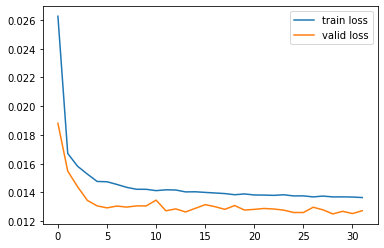

In [30]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="valid loss")
plt.legend()
plt.show()

In [31]:
# test 集上的 loss
model.evaluate(test_x, test_y, verbose=0)

0.012344185340761024

In [0]:
prediction = model.predict(test_x)

In [0]:
max_value = np.max(df["pm2.5"])
min_value = np.min(df["pm2.5"])
prediction = prediction[:, 0] * (max_value - min_value) + min_value

In [0]:
# 因为 look_back 处理时会去掉值为 nan 的 input
expectation = df["pm2.5"][split_point[1] + look_back: ].values

In [35]:
print("prediction's shape = {}, expectation's shape = {}".format(prediction.shape, expectation.shape))

prediction's shape = (8351,), expectation's shape = (8351,)


In [36]:
# 计算一下 R-square
print(r2_score(expectation, prediction, multioutput="raw_values"))

[0.94494617]


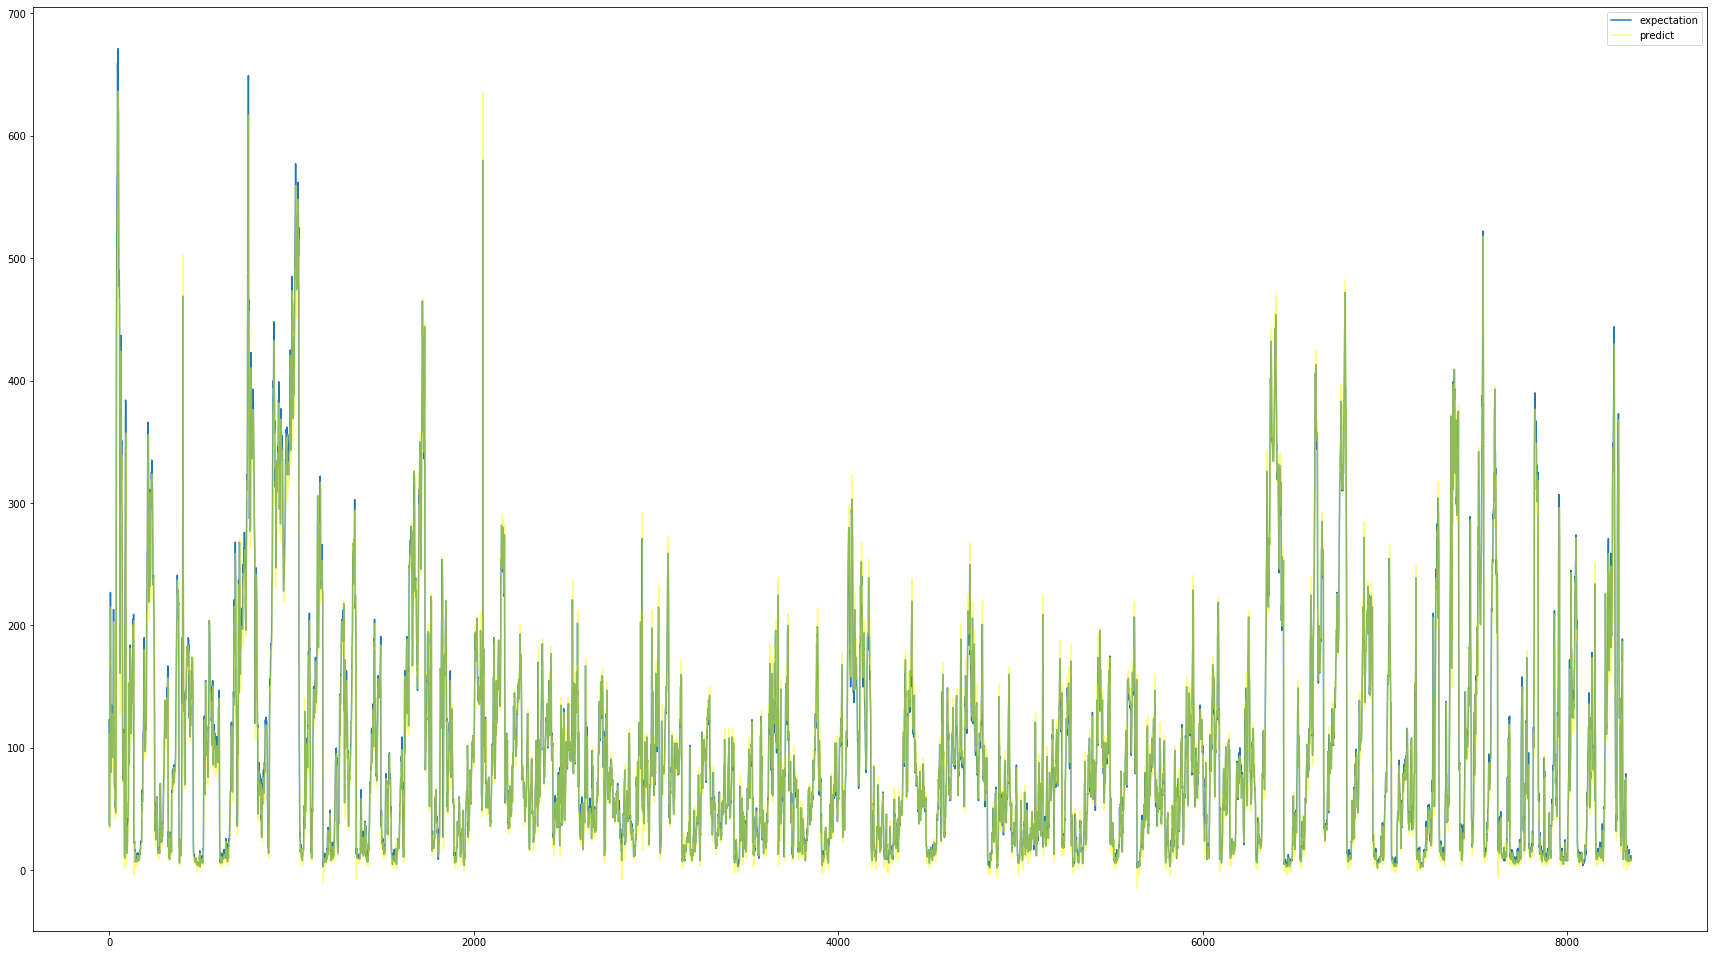

In [37]:
plt.figure(figsize=(30, 17))
plt.plot(expectation, label="expectation")
plt.plot(prediction, label="predict", color="yellow", alpha=0.5)
plt.legend()
plt.show()